In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
from time import time
import coremltools
%matplotlib notebook

# Part 1 : Access the data

<IPython.core.display.Javascript object>


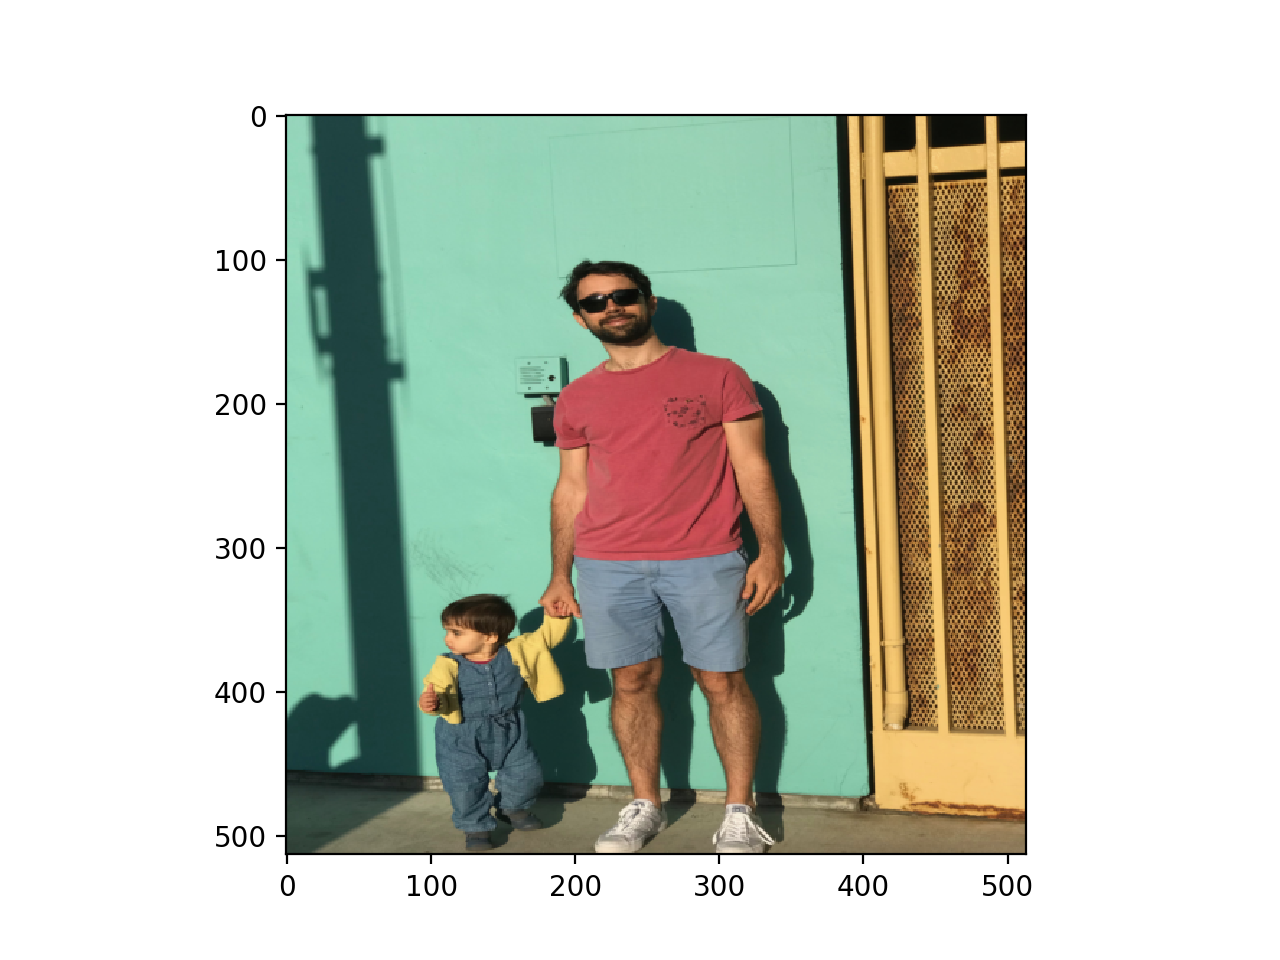

In [15]:
# Load the image
img_rgb = Image.open('../../../samples/person_matthieu.jpg')
img_y = img_rgb.convert('L')

# Load the model and it's specs
multi_array_model = coremltools.models.MLModel('../../../models/MultiArrayDeepLab.mlmodel')
input_width = model.get_spec().description.input[0].type.imageType.width
input_height = model.get_spec().description.input[0].type.imageType.height

# Resize the image to fit model's input size
small_img = img_rgb.resize((input_width, input_height), Image.BILINEAR)

# Plot
plt.figure()
plt.imshow(small_img)
plt.show()

<IPython.core.display.Javascript object>


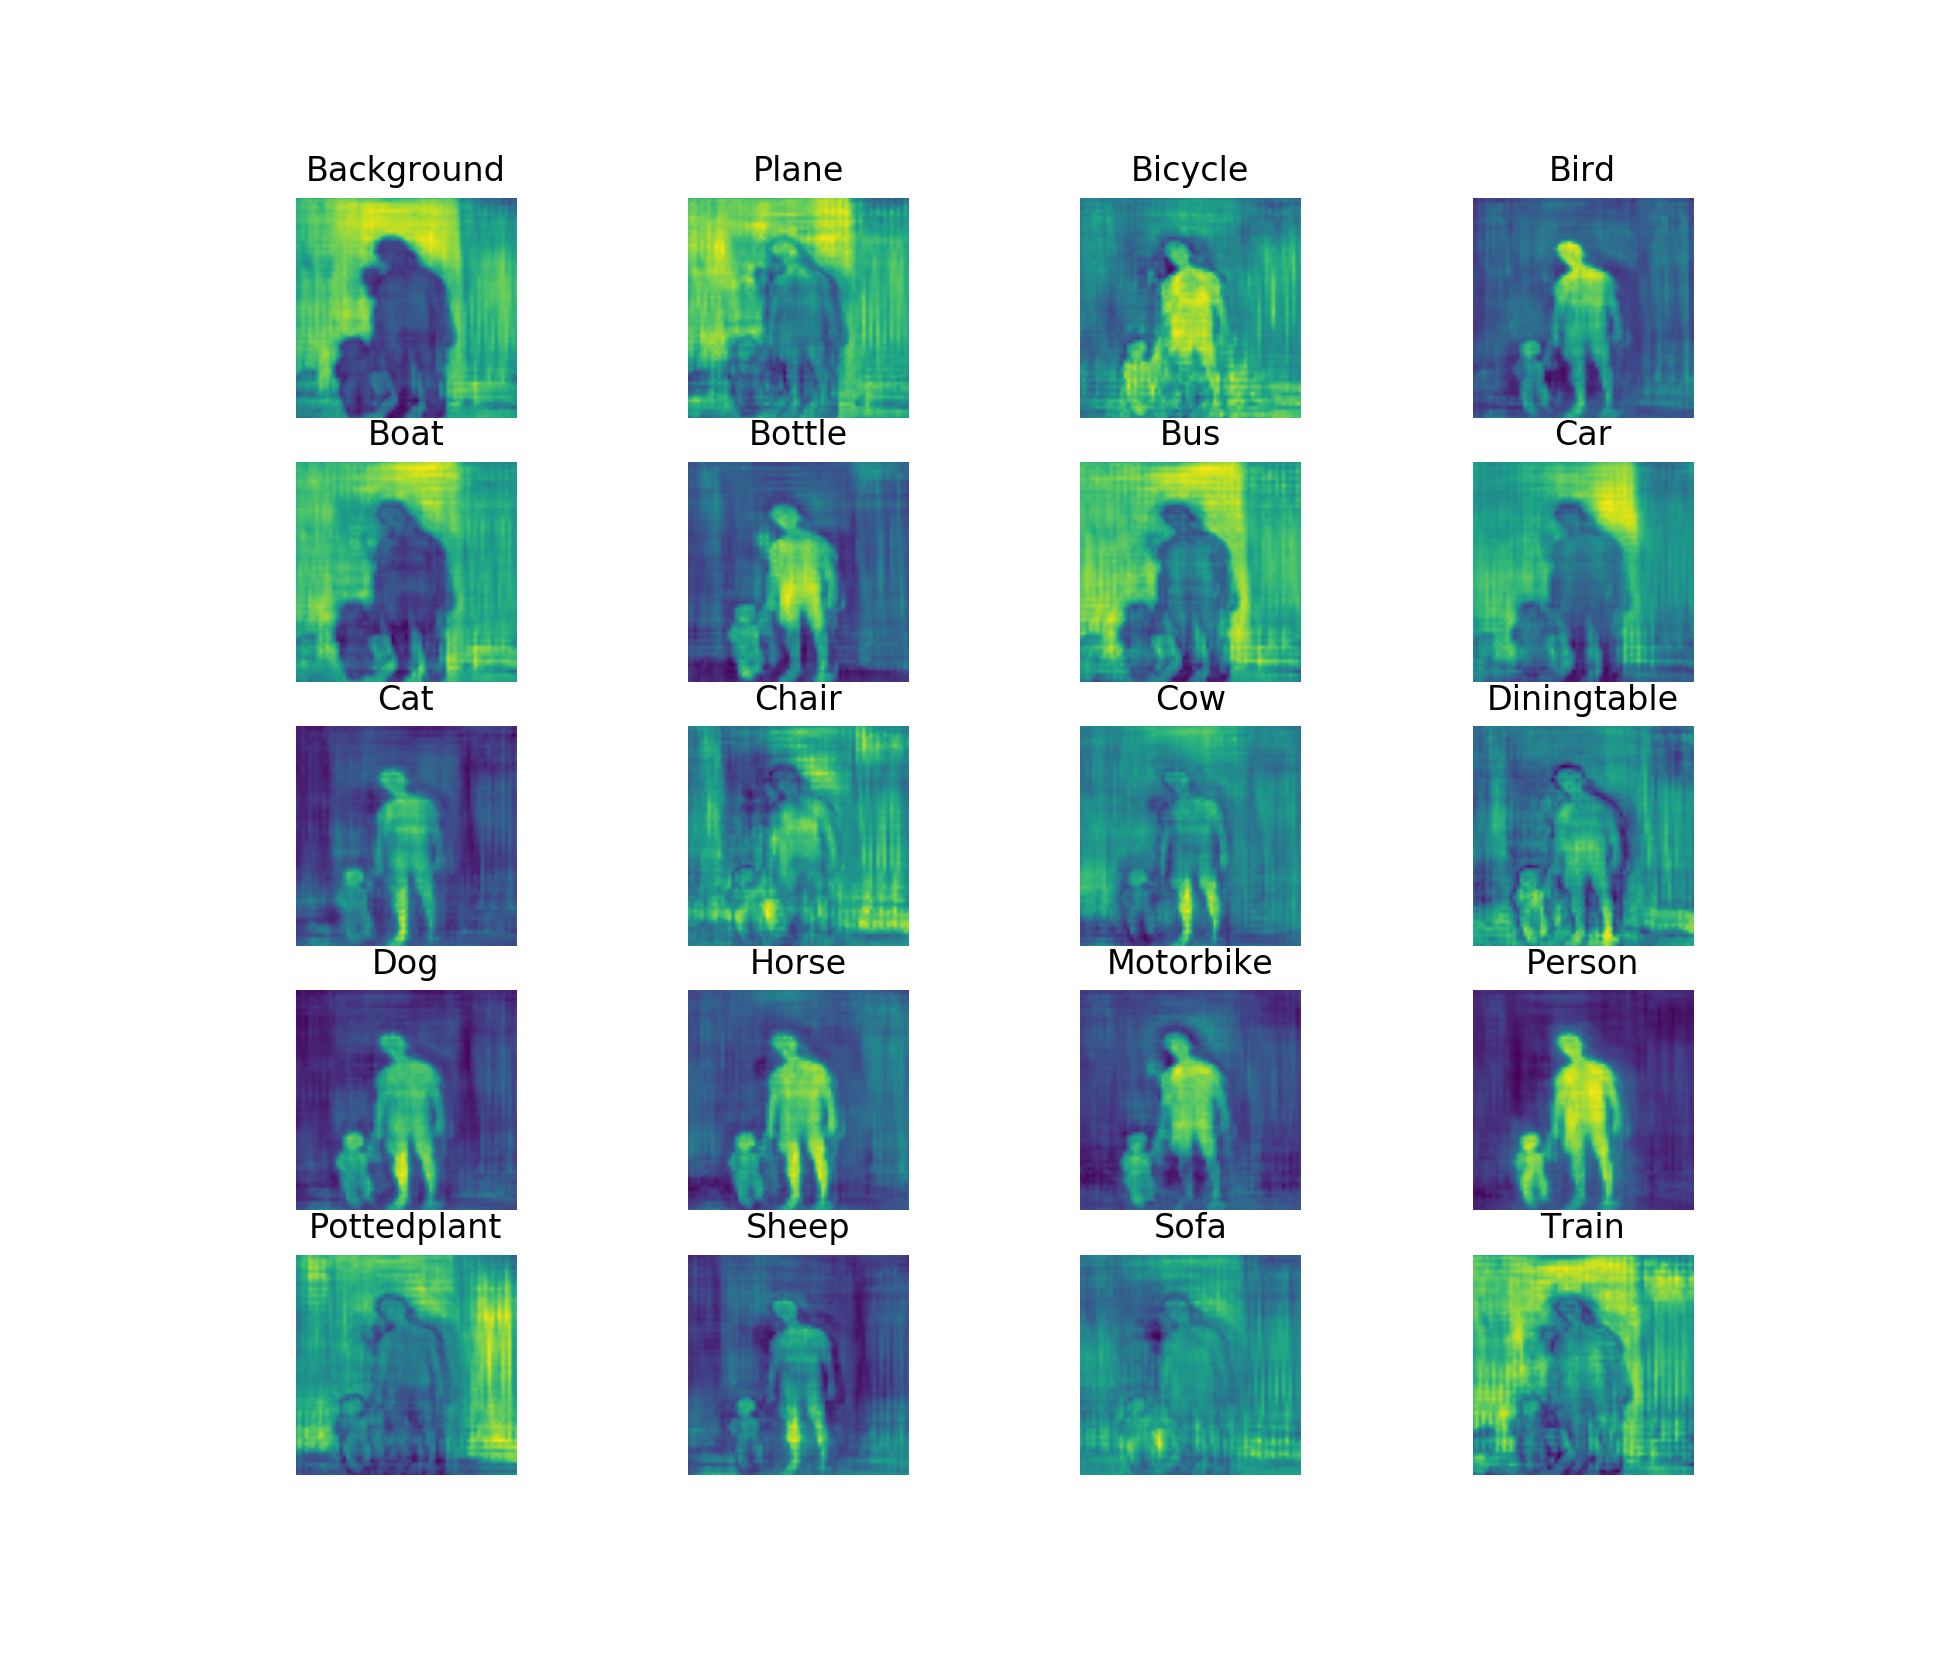

In [18]:
# Prediction
small_pred = multi_array_model.predict({"ImageTensor__0": small_img}, usesCPUOnly=False)
small_pred = small_pred['ResizeBilinear_3__0']
# print small_pred.shape

# Test plot
labels = ['Background','Plane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','Diningtable','Dog','Horse','Motorbike','Person','Pottedplant','Sheep','Sofa','Train','Tvmonitor']
f, ax = plt.subplots(5,4)
for j in range(5):
    for i in range(4):
        idx = j*4+i
        ax[j,i].imshow(small_pred[idx,:,:])
        ax[j,i].set_title(labels[idx])
        ax[j,i].set_axis_off()
plt.show()

# Part 2 : Preprocess the data

<IPython.core.display.Javascript object>


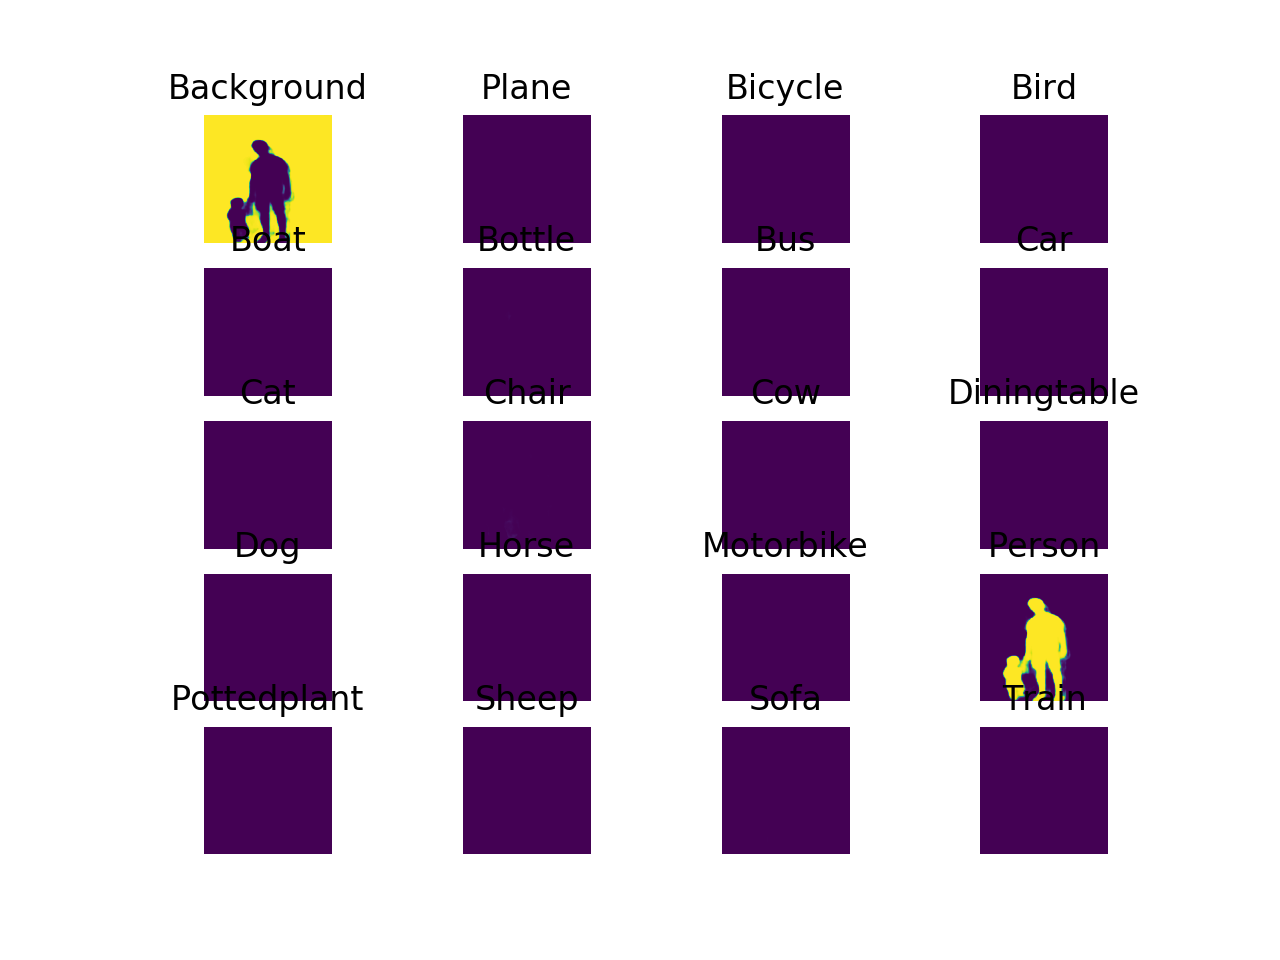

In [45]:
# Compute softmax
small_pred_softmax = np.exp(small_pred)
small_pred_softmax = small_pred_softmax / np.sum(small_pred_softmax, axis=0)
small_pred_softmax = small_pred_softmax.astype(np.float32)

# Test plot
f, ax = plt.subplots(5,4)
for j in range(5):
    for i in range(4):
        idx = j*4+i
        ax[j,i].imshow(small_pred_softmax[idx,:,:], vmin=0., vmax=1.)
        ax[j,i].set_title(labels[idx])
        ax[j,i].set_axis_off()
plt.show()

<IPython.core.display.Javascript object>


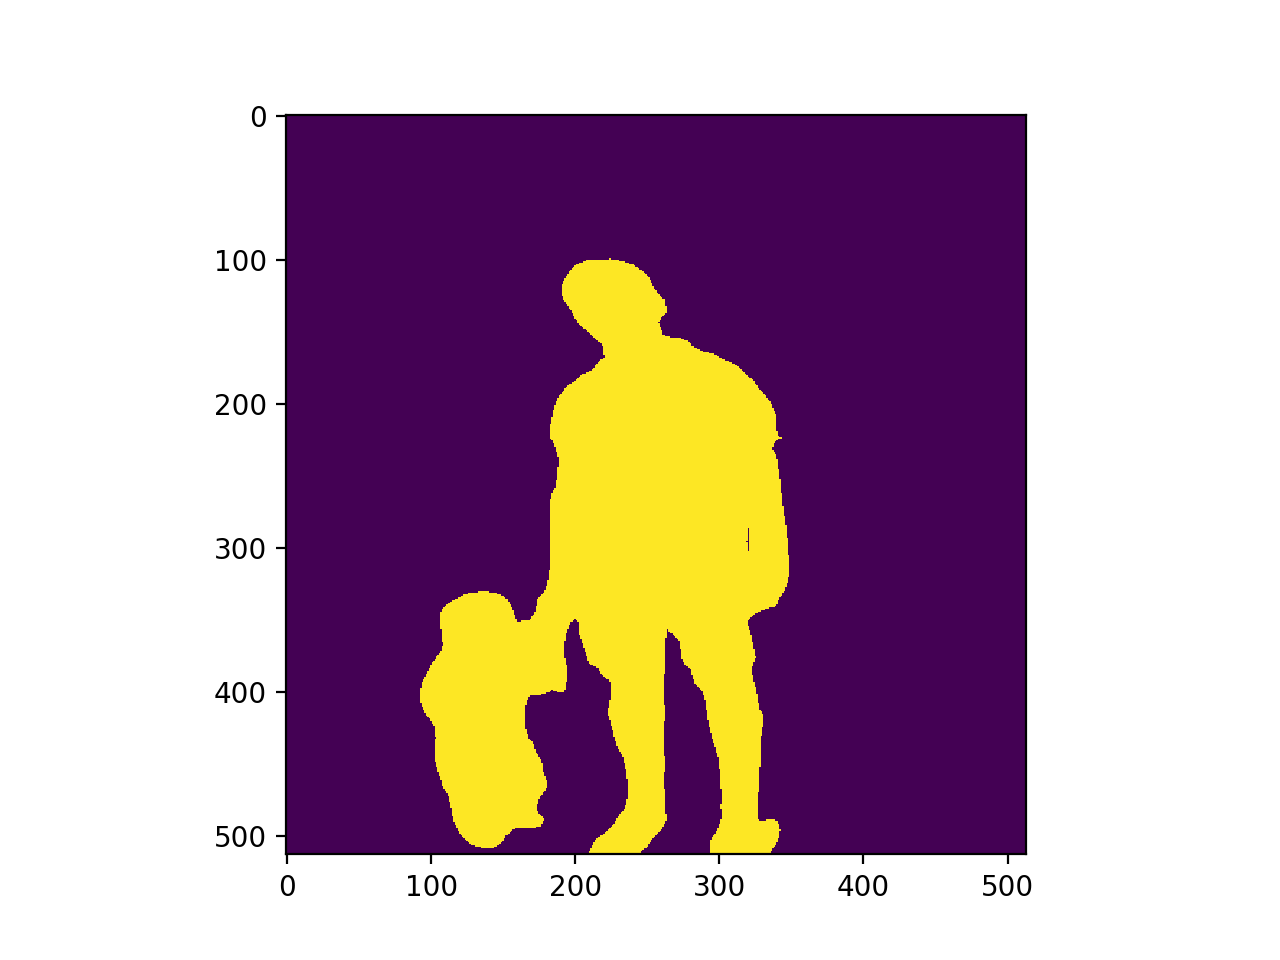

In [30]:
# Recompute the mask from raw prediction
plt.figure()
plt.imshow(np.argmax(small_pred_softmax, axis=0))
plt.show()

# Part 3 : Guided filter on the differente channels

<IPython.core.display.Javascript object>


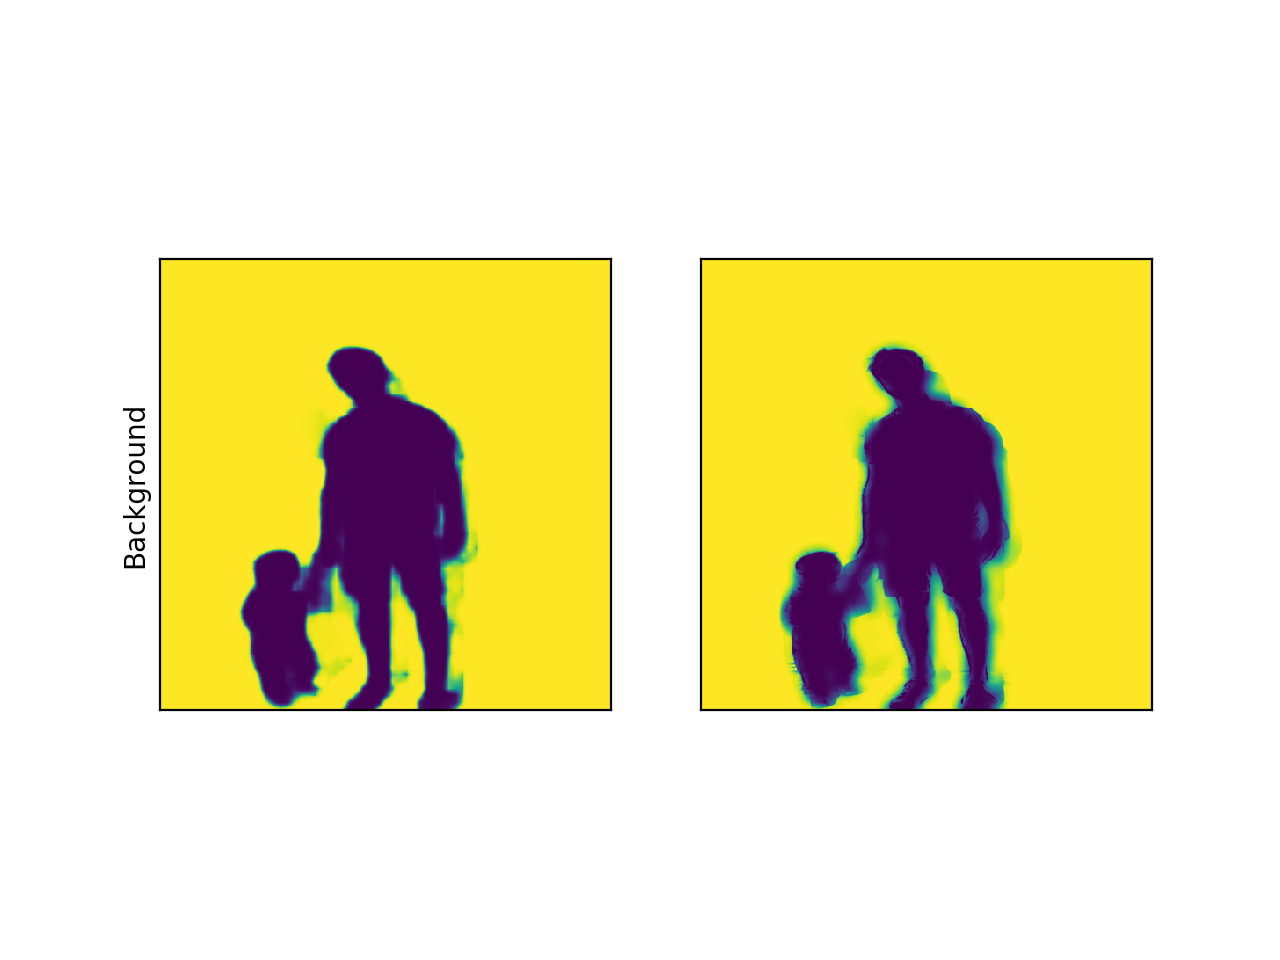

In [99]:
import cv2

# Convert the image
small_y = np.array(small_img.convert('L'), dtype=np.float32) / 255.

# Parameters
radius = 5
eps = 0.001

# Apply Guided filter
small_pred_softmax_gf = small_pred_softmax.copy()
for c in range(len(labels)):
    channel = small_pred_softmax[c,:,:]
    small_pred_softmax_gf[c,:,:] = np.clip(cv2.ximgproc.guidedFilter(small_y, channel, radius, eps), 0, 1.)
    
# Normalize the channels to sum to one
small_pred_softmax_gf = small_pred_softmax_gf / np.sum(small_pred_softmax_gf, axis=0)
    
# Plot
f, ax = plt.subplots(1,2)
ax[0].imshow(small_pred_softmax[0,:,:,])
ax[1].imshow(small_pred_softmax_gf[0,:,:,])
ax[0].set_ylabel(labels[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

<IPython.core.display.Javascript object>


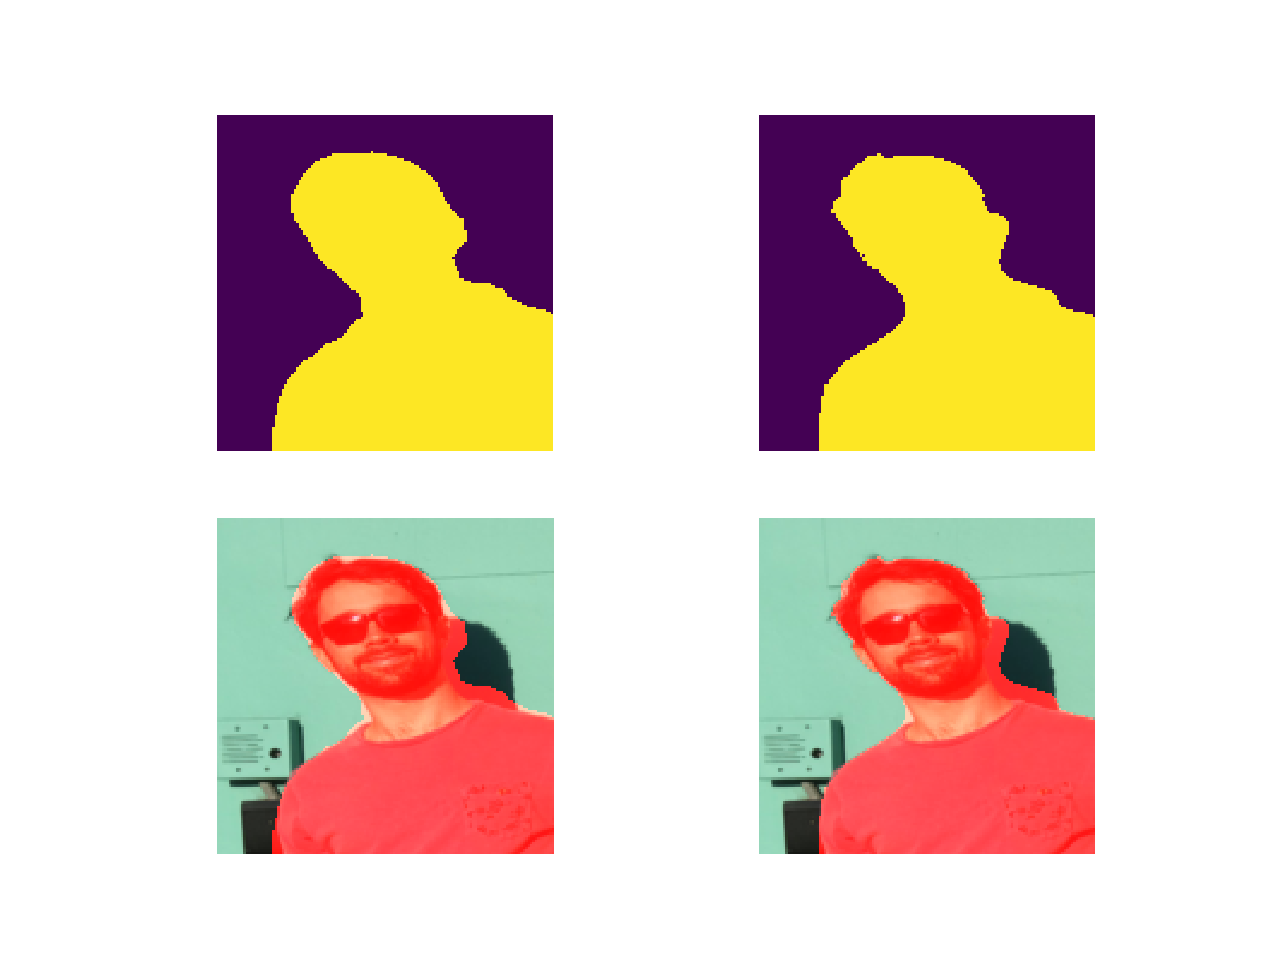

<IPython.core.display.Javascript object>


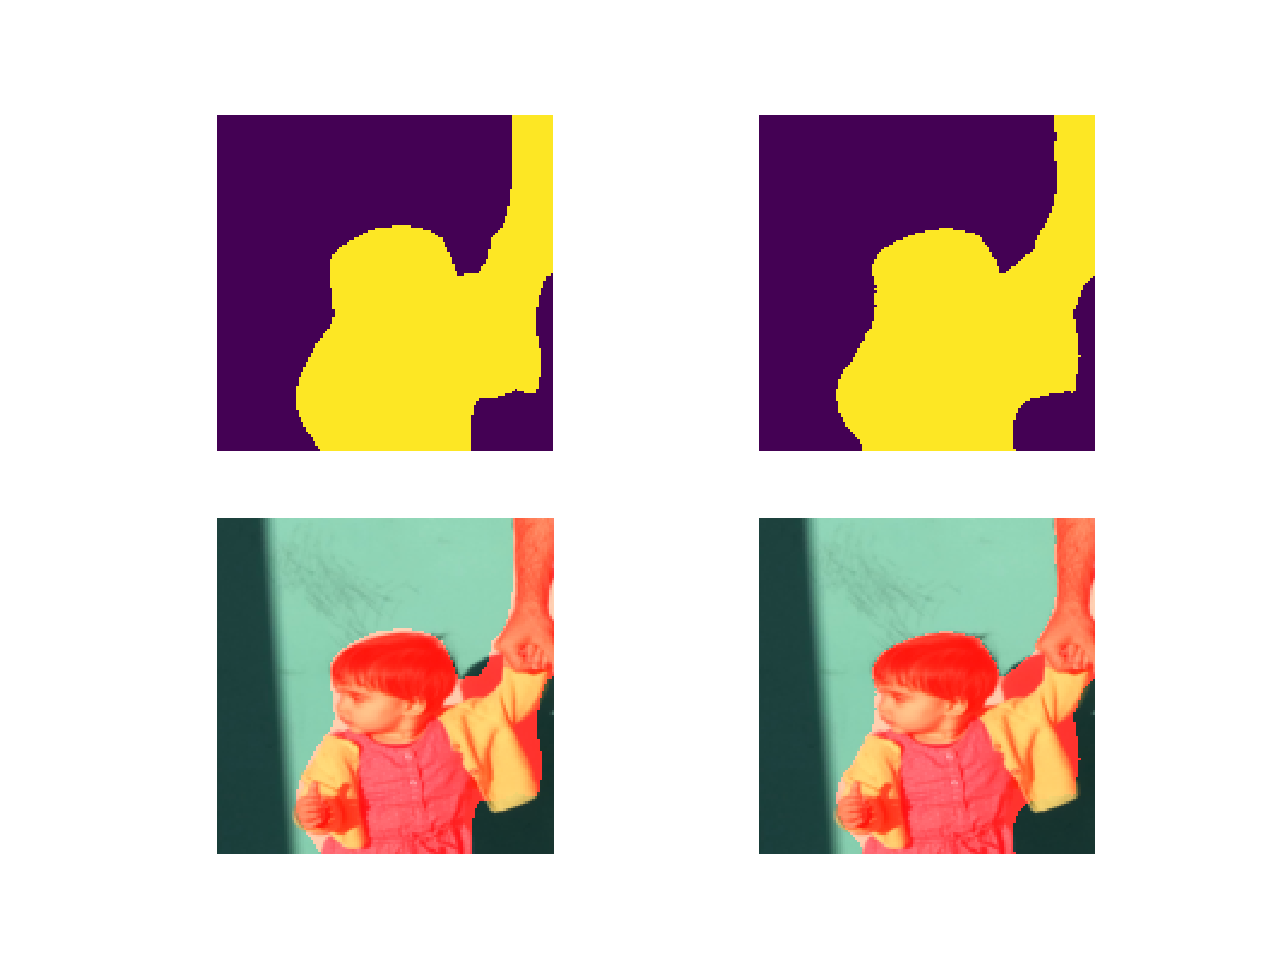

In [100]:
label2idx = {'Background':0,'Plane':1,'Bicycle':2,'Bird':3,'Boat':4,'Bottle':5,'Bus':6,'Car':7,'Cat':8,'Chair':9,'Cow':10,'Diningtable':11,'Dog':12,'Horse':13,'Motorbike':14,'Person':15,'Pottedplant':16,'Sheep':17,'Sofa':18,'Train':19,'Tvmonitor':20}

argmax0 = np.argmax(small_pred_softmax, axis=0)
argmax1 = np.argmax(small_pred_softmax_gf, axis=0)

what = 'Person'
where0 = argmax0 == label2idx[what]
where1 = argmax1 == label2idx[what]

mask0 = np.zeros(small_y.shape)
mask0[where0] = 1

mask1 = np.zeros(small_y.shape)
mask1[where1] = 1

red0 = np.array(small_img)
red0[:,:,0][where0] = 255

red1 = np.array(small_img)
red1[:,:,0][where1] = 255

# Crop
x = 160
y = 85
s = 140

# Recompute the mask from raw prediction
f, ax = plt.subplots(2,2)
ax[0,0].imshow(mask0[y:y+s, x:x+s])
ax[0,1].imshow(mask1[y:y+s, x:x+s])
ax[1,0].imshow(red0[y:y+s, x:x+s, :])
ax[1,1].imshow(red1[y:y+s, x:x+s, :])
ax[0,0].set_axis_off()
ax[0,1].set_axis_off()
ax[1,0].set_axis_off()
ax[1,1].set_axis_off()
plt.show()

# Crop
x = 60
y = 285
s = 140

# Recompute the mask from raw prediction
f, ax = plt.subplots(2,2)
ax[0,0].imshow(mask0[y:y+s, x:x+s])
ax[0,1].imshow(mask1[y:y+s, x:x+s])
ax[1,0].imshow(red0[y:y+s, x:x+s, :])
ax[1,1].imshow(red1[y:y+s, x:x+s, :])
ax[0,0].set_axis_off()
ax[0,1].set_axis_off()
ax[1,0].set_axis_off()
ax[1,1].set_axis_off()
plt.show()